In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
import numpy as np
import copy as copy
from IPython import display
import gc
plt.rcParams['figure.figsize'] = (18, 15)
plt.rcParams['font.size'] = 32

In [2]:
from matplotlib.ticker import FuncFormatter
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def formatter(x,pos):
    return format(np.log10(x), '.0f')

In [3]:
# ##########################################################
# Generate colors for histogram bars based on a normalized
# height. Normalize by bin width and comoving vol
# Method:
#  Take log of the histogram values (weighted counts)..
#  Create a LogNorm mapping between 1->max
#  Use the norm to map scalar values between 1 & max to rgb
# ##########################################################
def colorHistOnHeight(N, bins, patches, cmvol, minc, maxc):
    cleanN = np.ma.masked_where(N == 0.0, N)
    widths = np.diff(np.log10(bins))
    fracs  = np.log10(cleanN/widths/cmvol)

    # normalize colors to the top of our scale
    norm   = mpl.colors.LogNorm(vmin=minc, vmax=maxc) 
    sm     = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    sm.set_clim([minc, maxc]) # Force to use the whole range
    for thisfrac, thispatch in zip(fracs, patches):
        color = sm.to_rgba(thisfrac)
        thispatch.set_facecolor(color)
    return 
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and comoving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(np.log10(bins))
    #print ("patches %i, bins %i"%(len(patches),len(widths)))
    for item,dbx in zip(patches,widths):
        #print ("Starting height: %.2f bin width: %.2e"%(item.get_height(),dbx))
        if not rotated:
            item.set_height(item.get_height()/dbx/cmvol)
        else:
            item.set_width(item.get_width()/dbx/cmvol)
        #print ("Ending width: %.2f"%item.get_width())
    return

In [4]:
custom_formatter = FuncFormatter(formatter)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_2dhist = [left, bottom, width, height]
rect_histx = [left, bottom_h, width - 0.13, 0.15]
rect_histy = [left_h, bottom, 0.15, height]
labelsize = 28

In [5]:
prefix = "./"
z = "05.00"
locs   = np.loadtxt(prefix + "spLoc_" + z + ".txt", skiprows=1)
masses = np.loadtxt(prefix + "spMass_" + z + ".txt", skiprows=1)
spZ  = np.loadtxt(prefix + "spZ_" + z + ".txt", skiprows=1)
spPZ = np.loadtxt(prefix + "spPZ_" + z + ".txt", skiprows=1)
spPF = np.loadtxt(prefix + "spPPF_" + z + ".txt", skiprows=1)

In [6]:
# Determine which stars are completely primordial (PM) at this redshift.
spZmPZ = (spZ - spPZ)
priStars = (spZmPZ == 0.0) # This is a conditional check. Selects star particles with only PM
mixedStar = (spZmPZ > 0.0) # Select stars with both primordial and regular metals

## 25 M_sun Pop III SN mass fractions
<|H -> 67.2466, He -> 36.2852, 
 C -> 0.864672, N -> 0.00100878, O -> 0.13237, 
 F -> 7.35231*10^-10, Ne -> 0.00181426, Na -> 1.07003*10^-7, 
 Mg -> 0.0000405398, Al -> 1.28539*10^-7, Si -> 0.0000242565, 
 P -> 6.74577*10^-9, S -> 0.0000142174, Cl -> 9.36997*10^-9, 
 Ar -> 2.68986*10^-6, K -> 2.81018*10^-9, Ca -> 3.71304*10^-6, 
 Sc -> 2.69701*10^-11, Ti -> 5.73999*10^-8, V -> 2.31868*10^-9, 
 Cr -> 9.63105*10^-7, Mn -> 1.57773*10^-7, Fe -> 0.0000474087, 
 Co -> 3.87723*10^-8, Ni -> 6.47289*10^-7|>
## Sun's mass fractions, X_{i,sun}
### Use these values when modeling solar metal fractions
#### Solar values based on Asplund
<|H -> 0.735999, He -> 0.250575, 
 C -> 0.00237716, N -> 0.000696635, O -> 0.00576763, 
 F -> 5.07728*10^-7, Ne -> 0.00125287, Na -> 0.0000294175, 
 Mg -> 0.000703216, Al -> 0.0000560069, Si -> 0.000666861, 
 P -> 5.86461*10^-6, S -> 0.000310476, Cl -> 8.14602*10^-6, 
 Ar -> 0.0000739499, K -> 3.07569*10^-6, Ca -> 0.0000644076, 
 Sc -> 4.67832*10^-8, Ti -> 3.14861*10^-6, V -> 3.19483*10^-7, 
 Cr -> 0.0000167063, Mn -> 0.0000108953, Fe -> 0.00130336, 
 Co -> 4.24355*10^-6, Ni -> 0.0000708444|>
 ## Sun's mass fractions based on solar metals only
 ### Use these when computing fraction of regular, solar Z
 #### Xsunmetal values...
 <|H -> 54.8198, He -> 18.6637, 
 C -> 0.177059, N -> 0.0518878, O -> 0.429593, 
 F -> 0.0000378173, Ne -> 0.0933184, Na -> 0.00219112, Mg -> 0.052378,
  Al -> 0.00417159, Si -> 0.0496701, P -> 0.000436817, S -> 0.0231253,
  Cl -> 0.000606744, Ar -> 0.00550804, K -> 0.000229088, 
 Ca -> 0.00479731, Sc -> 3.48458*10^-6, Ti -> 0.000234519, 
 V -> 0.0000237962, Cr -> 0.00124434, Mn -> 0.000811522, 
 Fe -> 0.097079, Co -> 0.000316074, Ni -> 0.00527674|>

In [7]:
# Mass fractions for 25 M_sun Pop III SN
C25sn = 0.864672; N25sn =0.00100878; O25sn = 0.13237; Mg25sn = 0.0000405398; Ca25sn = 3.71304e-6;Fe25sn = 0.0000474087;
# Mass fractions for 1 Gyr mass fractions from Franks model
Cf = 0.1681540187750919 ; Nf =0.0792975; Of = 0.528584 ; Mgf=0.0249245; Caf=0.00300647 ;Fef = 0.0539277;
# Solar mass fractions
Csunmetal = 0.177059; Nsunmetal =0.0518878; Osunmetal = 0.429593; Mgsunmetal= 0.052378; Casunmetal=0.00479731;Fesunmetal = 0.097079; 
# Used to normalize the mass fractions and convert to number densities.
Csun = 0.00237716; Nsun =0.000696635; Osun = 0.00576763; Mgsun=0.000703216; Casun=0.0000644076; Fesun = 0.00130336; 

In [8]:
# Compute fractions of PM based on 25 M_sun Pop III SN abundances 
# spPZ is already in solar units (i.e. if spPZ = 1.0 we have solar metallicity for that star particle),
# so convert spPZ back to mass fraction first. 
# What we're doing: (Z_P * 0.02) * X_sn results in the mass fraction of that element as if it came from that SN
CH = spPZ[priStars] * 0.02 * C25sn
NH = spPZ[priStars] * 0.02 * N25sn
OH = spPZ[priStars] * 0.02 * O25sn
MgH = spPZ[priStars] * 0.02 * Mg25sn
CaH = spPZ[priStars] * 0.02 * Ca25sn
FeH = spPZ[priStars] * 0.02 * Fe25sn

In [9]:
MgH/Mgsun/(CaH/Casun)

array([ 1.0000008,  1.0000008,  1.0000008, ...,  1.0000008,  1.0000008,
        1.0000008])

In [10]:
np.average(CH),np.average(MgH),np.average(CaH),np.average(MgH/CaH)

(4.9908816828411889e-08,
 2.3399548643421461e-12,
 2.1431644974807378e-13,
 10.918223342597978)

In [11]:
# For stars with regular Z and PZ, assume solar composition for regular Z, and the yields from a 25 M Pop III SN
# for the PM part. 
CH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Csunmetal + spPZ[mixedStar] * 0.02 * C25sn
NH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Nsunmetal + spPZ[mixedStar] * 0.02 * N25sn
OH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Osunmetal + spPZ[mixedStar] * 0.02 * O25sn
FeH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Fesunmetal + spPZ[mixedStar] * 0.02 * Fe25sn
# Note that we if Osun and Csun, etc. were standard solar metal mass fractions I could just multiply Z by Csun,etc.
# However, since the Asplund data doesn't result in a 0.02 solar metal fraction, we need to normalize Z by 0.02 
# and then multiply by the Asplund metal fractions...
# 
# Next we should use Frank's results to scale the "regular Z" since it really isn't "regular", but Fe depleted.
#
CH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Cf + spPZ[mixedStar] * 0.02 * C25sn
NH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Nf + spPZ[mixedStar] * 0.02 * N25sn
OH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Of + spPZ[mixedStar] * 0.02 * O25sn
MgH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Mgf + spPZ[mixedStar] * 0.02 * Mg25sn
CaH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Caf + spPZ[mixedStar] * 0.02 * Ca25sn
FeH_mixedF = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Fef + spPZ[mixedStar] * 0.02 * Fe25sn


In [37]:
# Keller data
CHFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/CH-FeH.txt", skiprows=1);
OHFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/OH-FeH Keller.txt", skiprows=1);
MgCaFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/MgCa-FeH Keller.txt", skiprows=1);

In [133]:
Oindices=[[0,1],[2*4,2*4+1],[2*5,2*5+1],[2*8,2*8+1],[2*11,2*11+1],[2*12,2*12+1],[2*15,2*15+1]] # The O values are upper bounds. Need error bars for them in plots

In [150]:
MgCaFeH

array([[-7.196,  2.897],
       [-5.759,  1.257],
       [-5.541,  0.127],
       [-4.809, -0.014],
       [-4.082, -0.152],
       [-4.059,  0.118],
       [-4.02 ,  1.624],
       [-3.964,  0.986],
       [-3.899,  0.172],
       [-3.748, -0.079],
       [-3.674,  0.244],
       [-3.546,  0.693],
       [-3.516,  0.087],
       [-3.49 ,  1.506],
       [-3.481, -0.763],
       [-3.477,  1.148],
       [-3.463,  0.644],
       [-3.346, -0.046],
       [-3.194, -0.162],
       [-2.989,  0.028],
       [-2.871, -0.115],
       [-2.868,  0.028],
       [-2.789, -0.059],
       [-2.522, -0.191]])

In [12]:
cmvol = 27.0 / (0.71)**3 # We're 'per h' so the volume is bigger than 27 Mpc^3

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


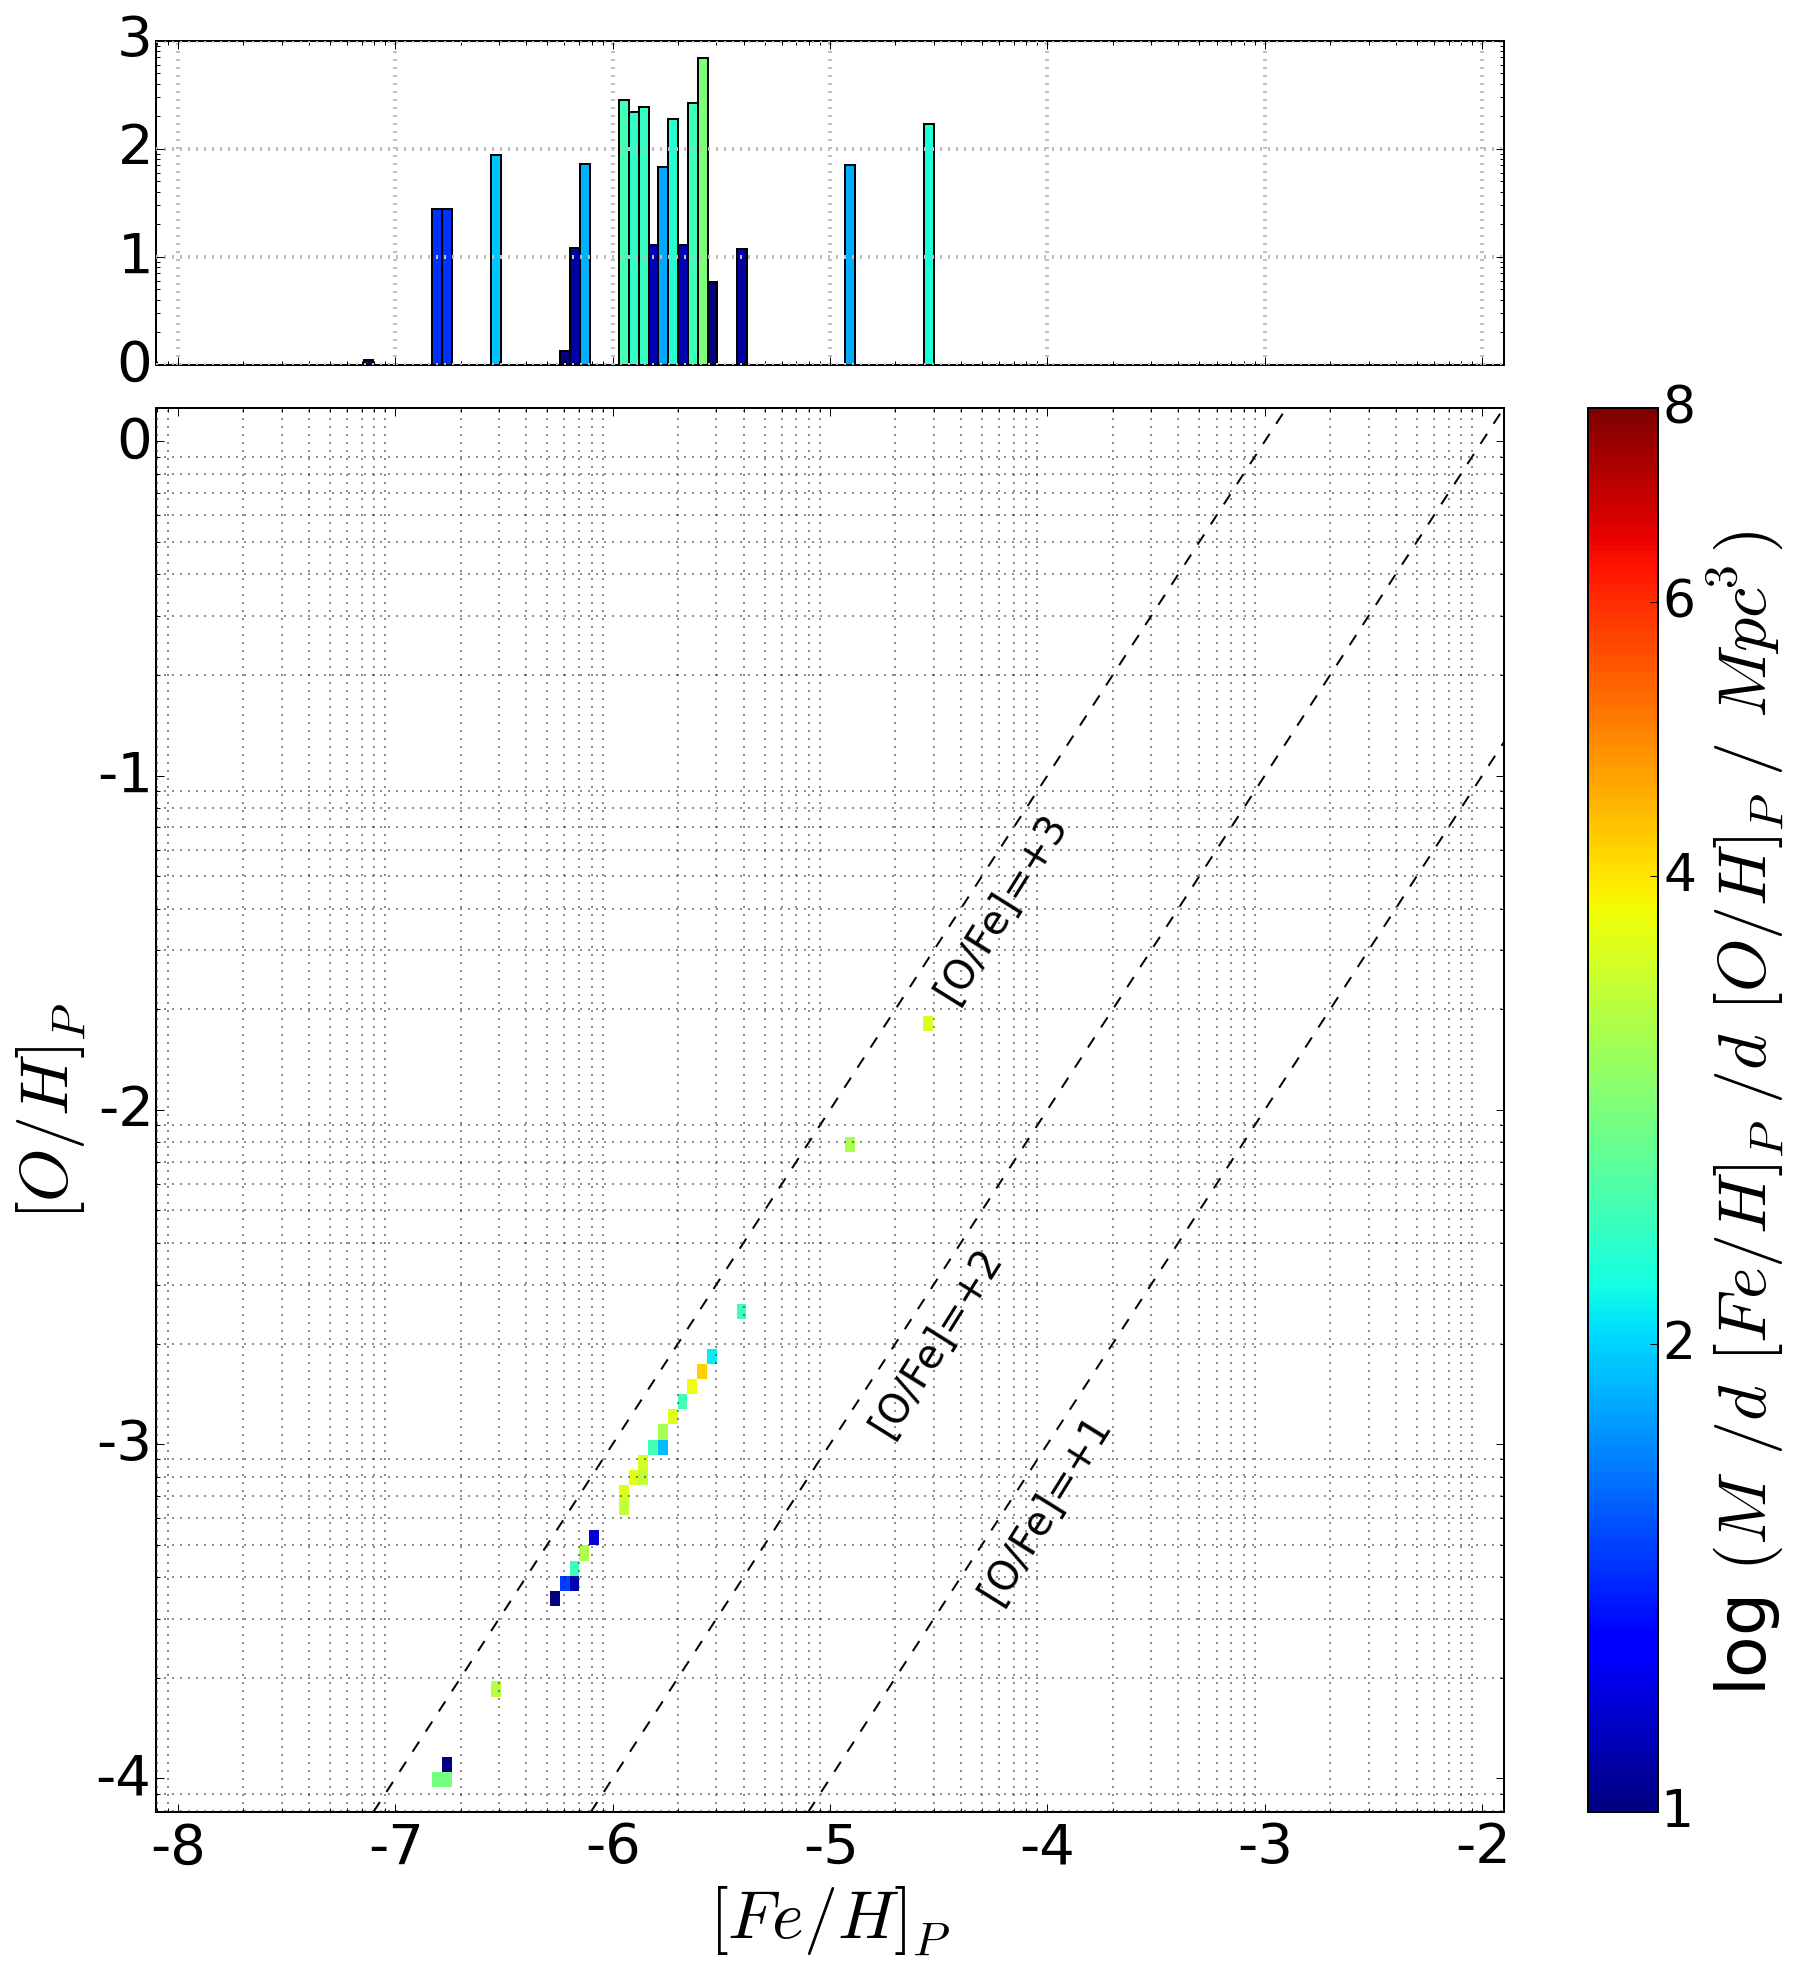

In [94]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
# Plot [O/H] vs [Fe/H]
yLabel = "[O/H]_{P}"
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plot = "[O/H]"
H, xedges, yedges = np.histogram2d(OH/Osun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)

#axHisty = plt.axes(rect_histy)

nullfmt = NullFormatter()

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

histMax = 3
cbarMax = 8
cbarMin = 1

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6., 10**-4), xytext=(10**-4.0, 10**-3), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6., 10**-4), xytext=(10**-4.5, 10**-2.50), 
                  horizontalalignment='center',size=20,rotation=58.0) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6., 10**-4), xytext=(10**-4.2, 10**-1.2), 
                  horizontalalignment='center',size=20,rotation=58.0) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1,2,4,6,cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Values should be along the 25 M_sun O yield line: [O/Fe] = 2.8

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH/Fesun, bins=xrange, log=True, 
                                weights=masses[priStars] * (1.0 - spPF[priStars]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([10.0**0.0,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e0,1e1, 1e2, 1e3])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH/Osun, bins=yrange, log=True, weights=masses[priStars] * (1.0 - spPF[priStars]),
#                                        orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([10.0**0.7,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e1, 1e2, 1e3])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


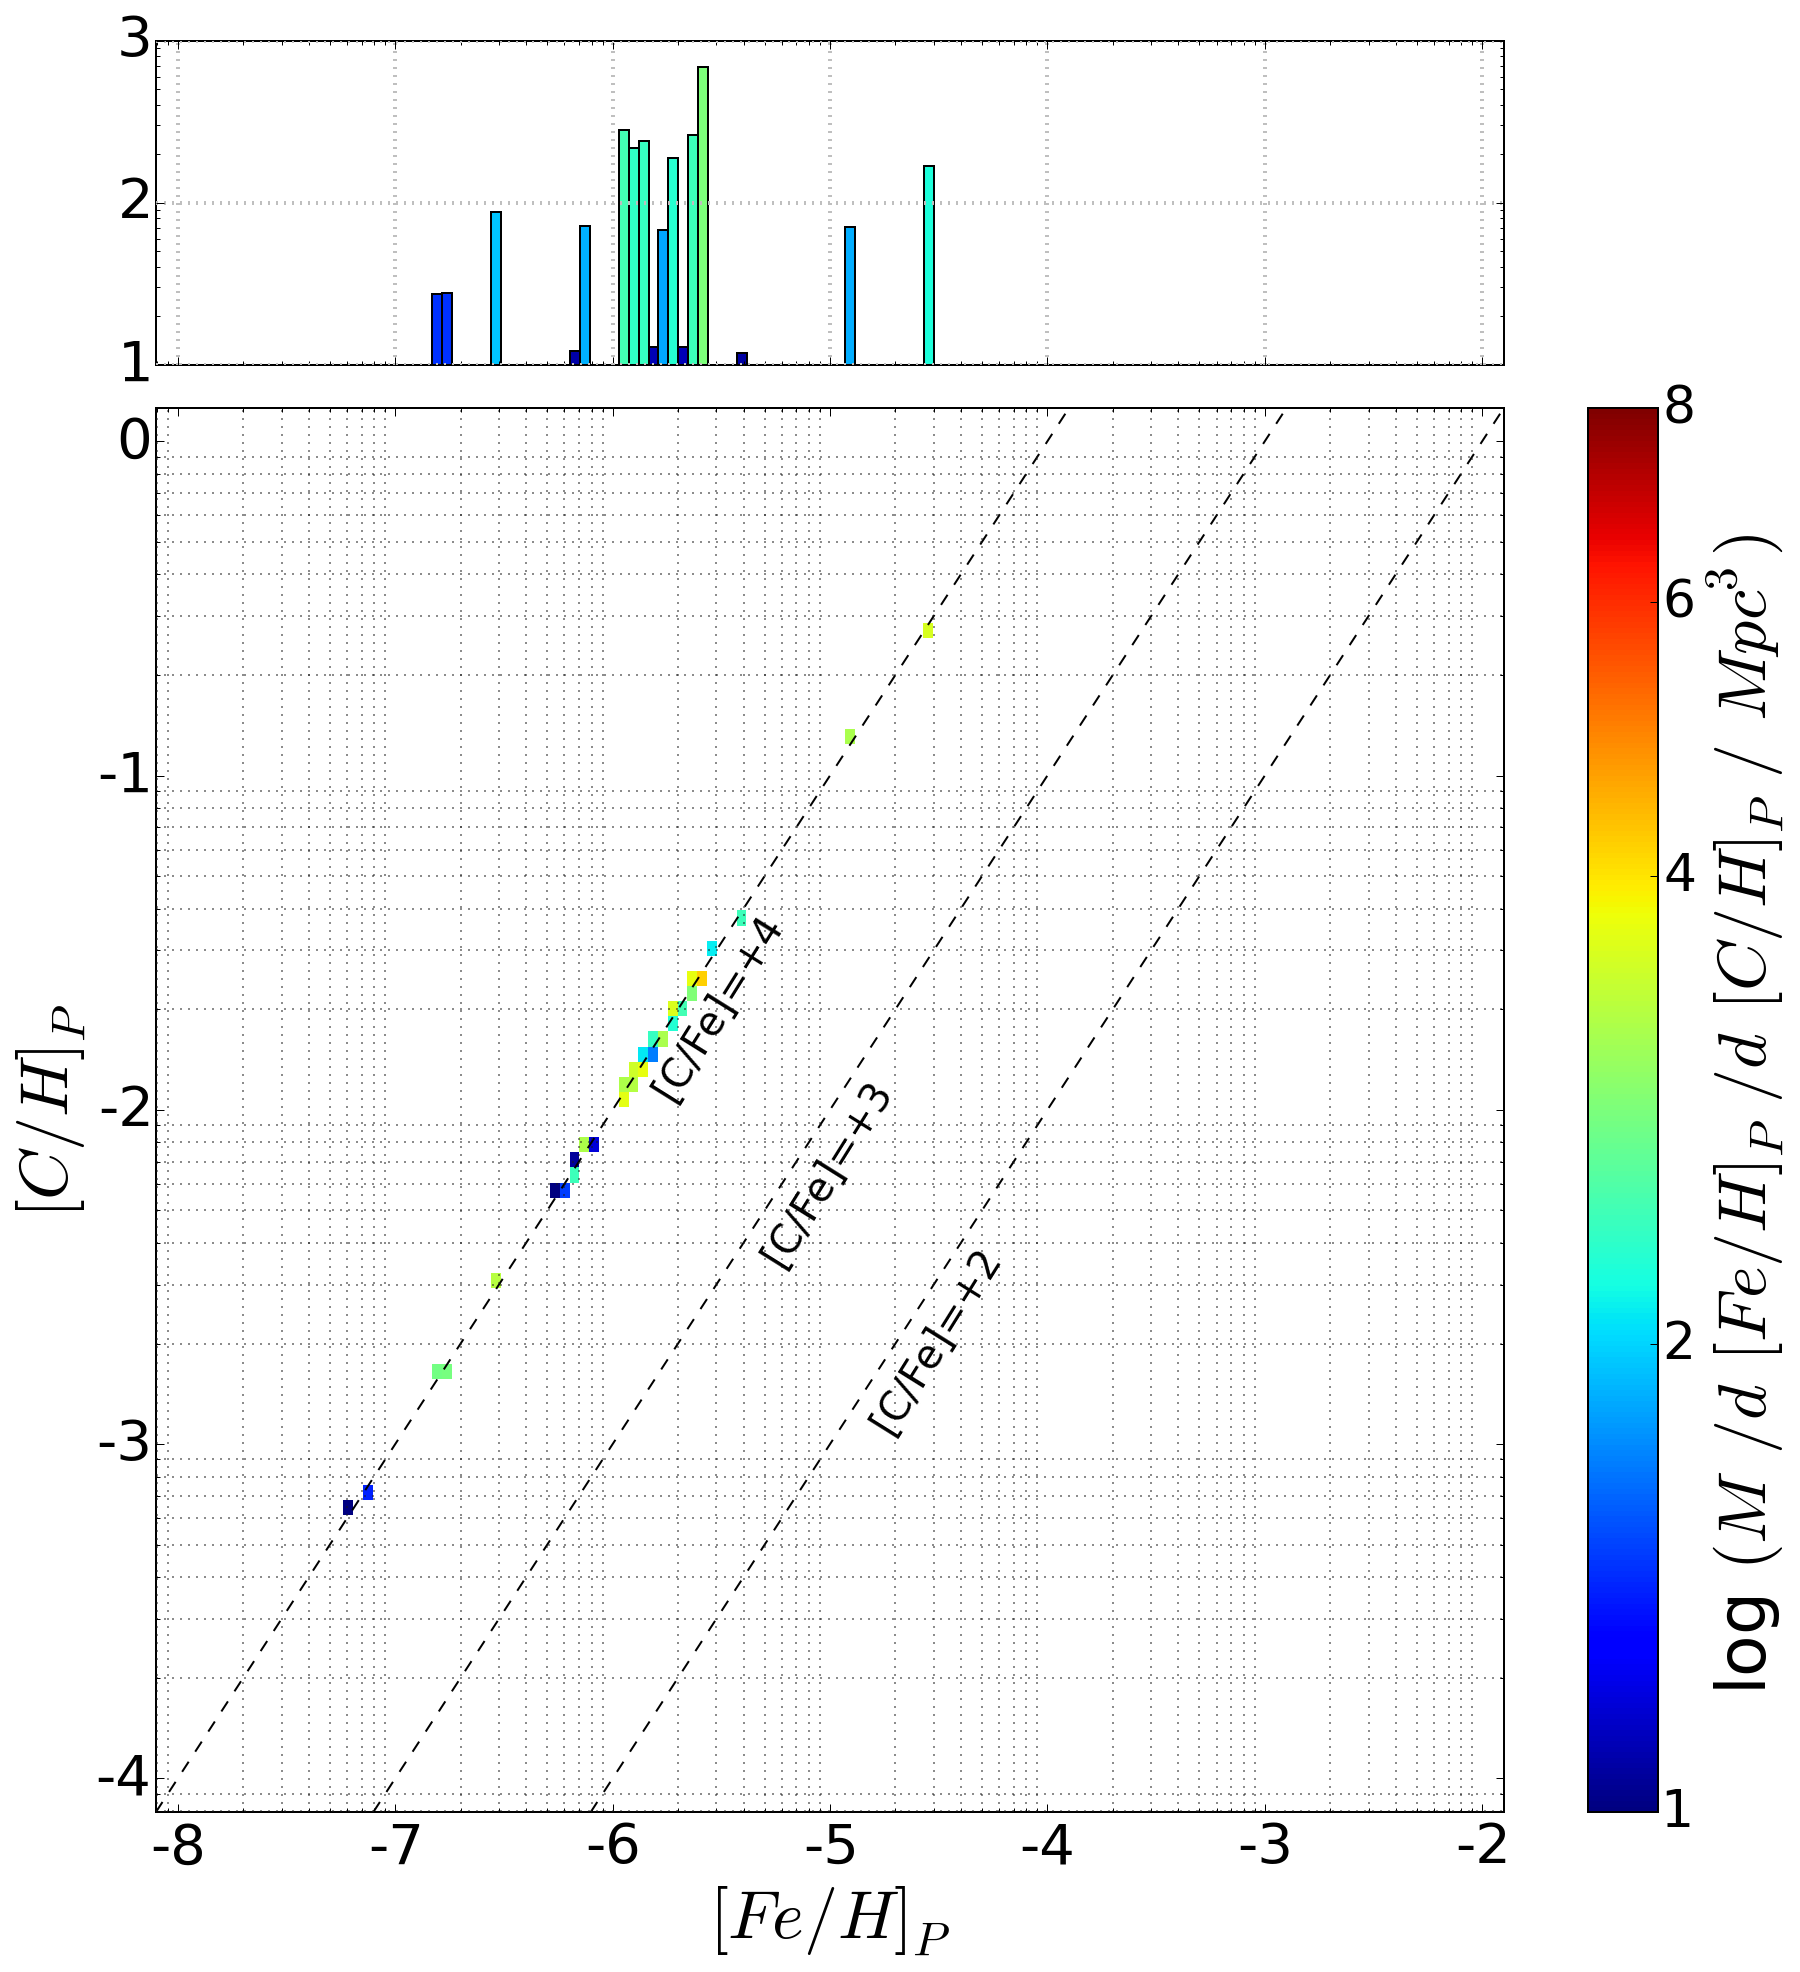

In [96]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{P}"
H, xedges, yedges = np.histogram2d(CH/Csun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 1
cbarMax = 8
histMax = 3

nullfmt = NullFormatter()

ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[C/Fe]=+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.5, 10**-2.5), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5, 10**-2), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-6.9, 10**-4), xytext=(10**-5.5, 10**-1.5), 
                  horizontalalignment='center',size=20,rotation=58.0)

# All values should be on the +4 line
ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1,2,4,6, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH/Fesun, bins=xrange, log=True, 
                                weights=masses[priStars] * (1.0 - spPF[priStars]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([10.0**1.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e1, 1e2, 1e3])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH/Csun, bins=yrange, log=True, weights=masses[priStars] * (1.0 - spPF[priStars]),
#                                        orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([10.0**1.7,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e1, 1e2, 1e3])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


In [29]:
gc.collect()

74

/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


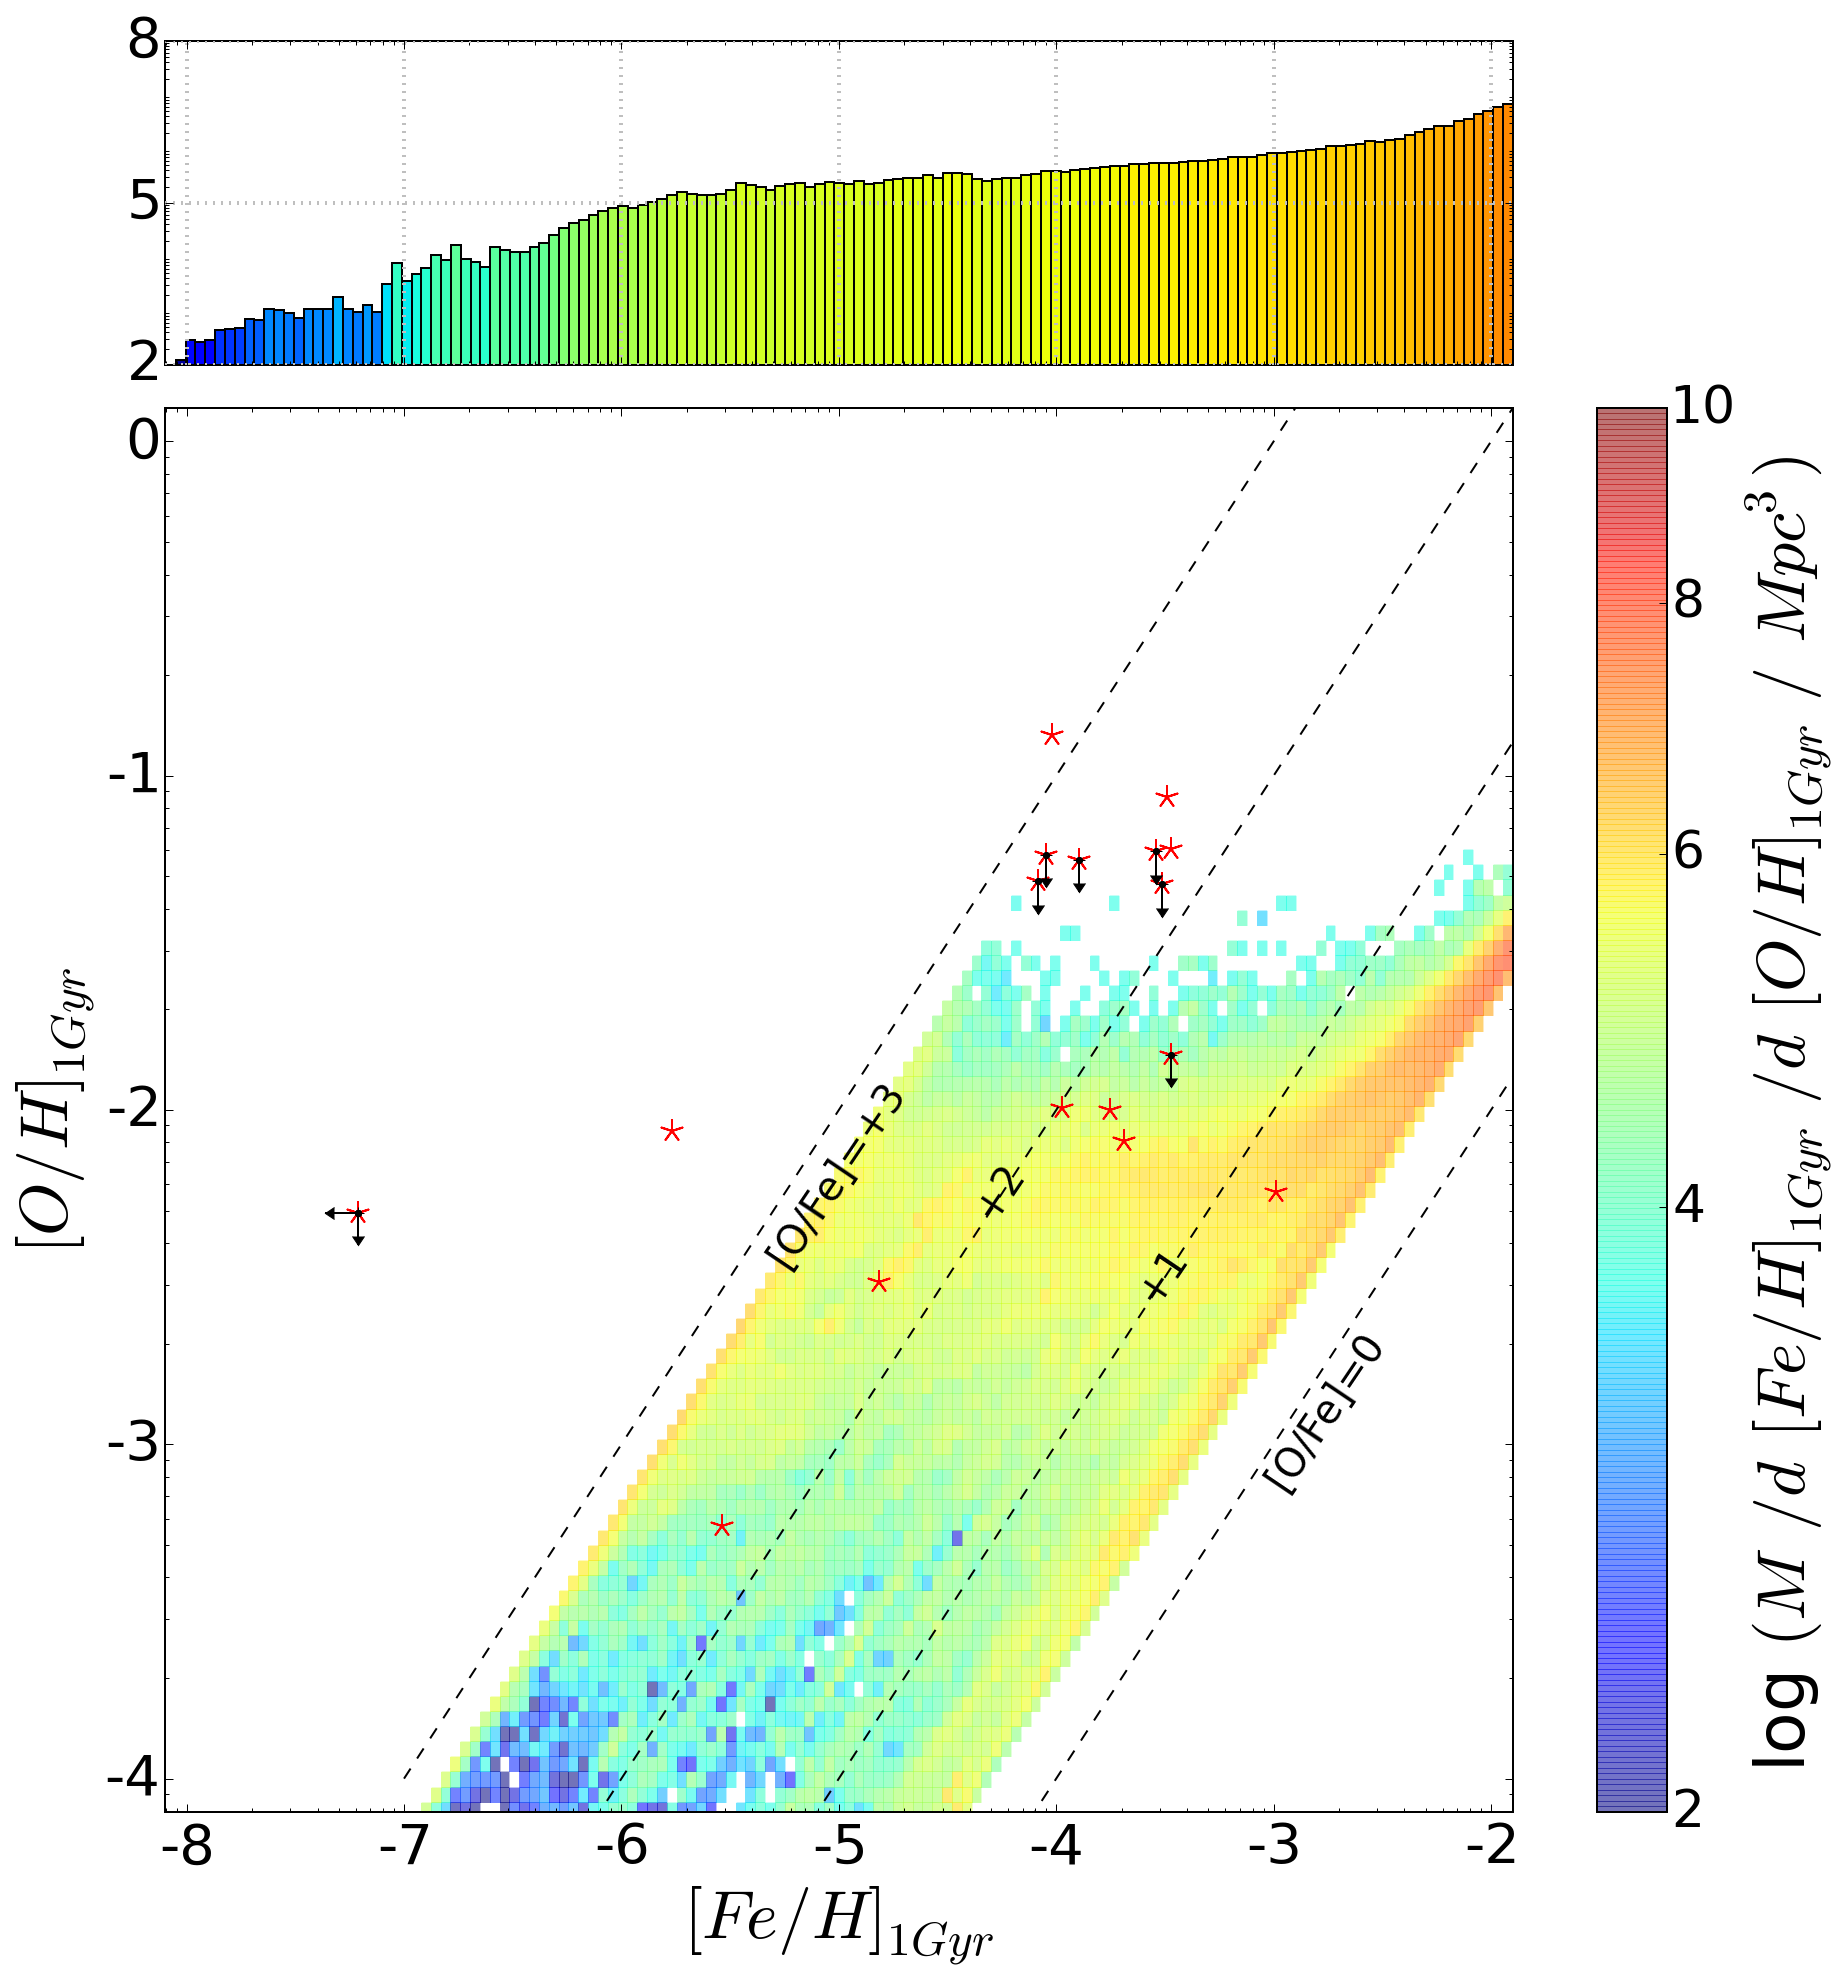

In [179]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]_{1Gyr}"

H, xedges, yedges = np.histogram2d(OH_mixedF/Osun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=56.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ax2dhist.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))
#ax2dhist.errorbar(10**OHFeH[:,0], 10**OHFeH[:,1],  )

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH_mixedF/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


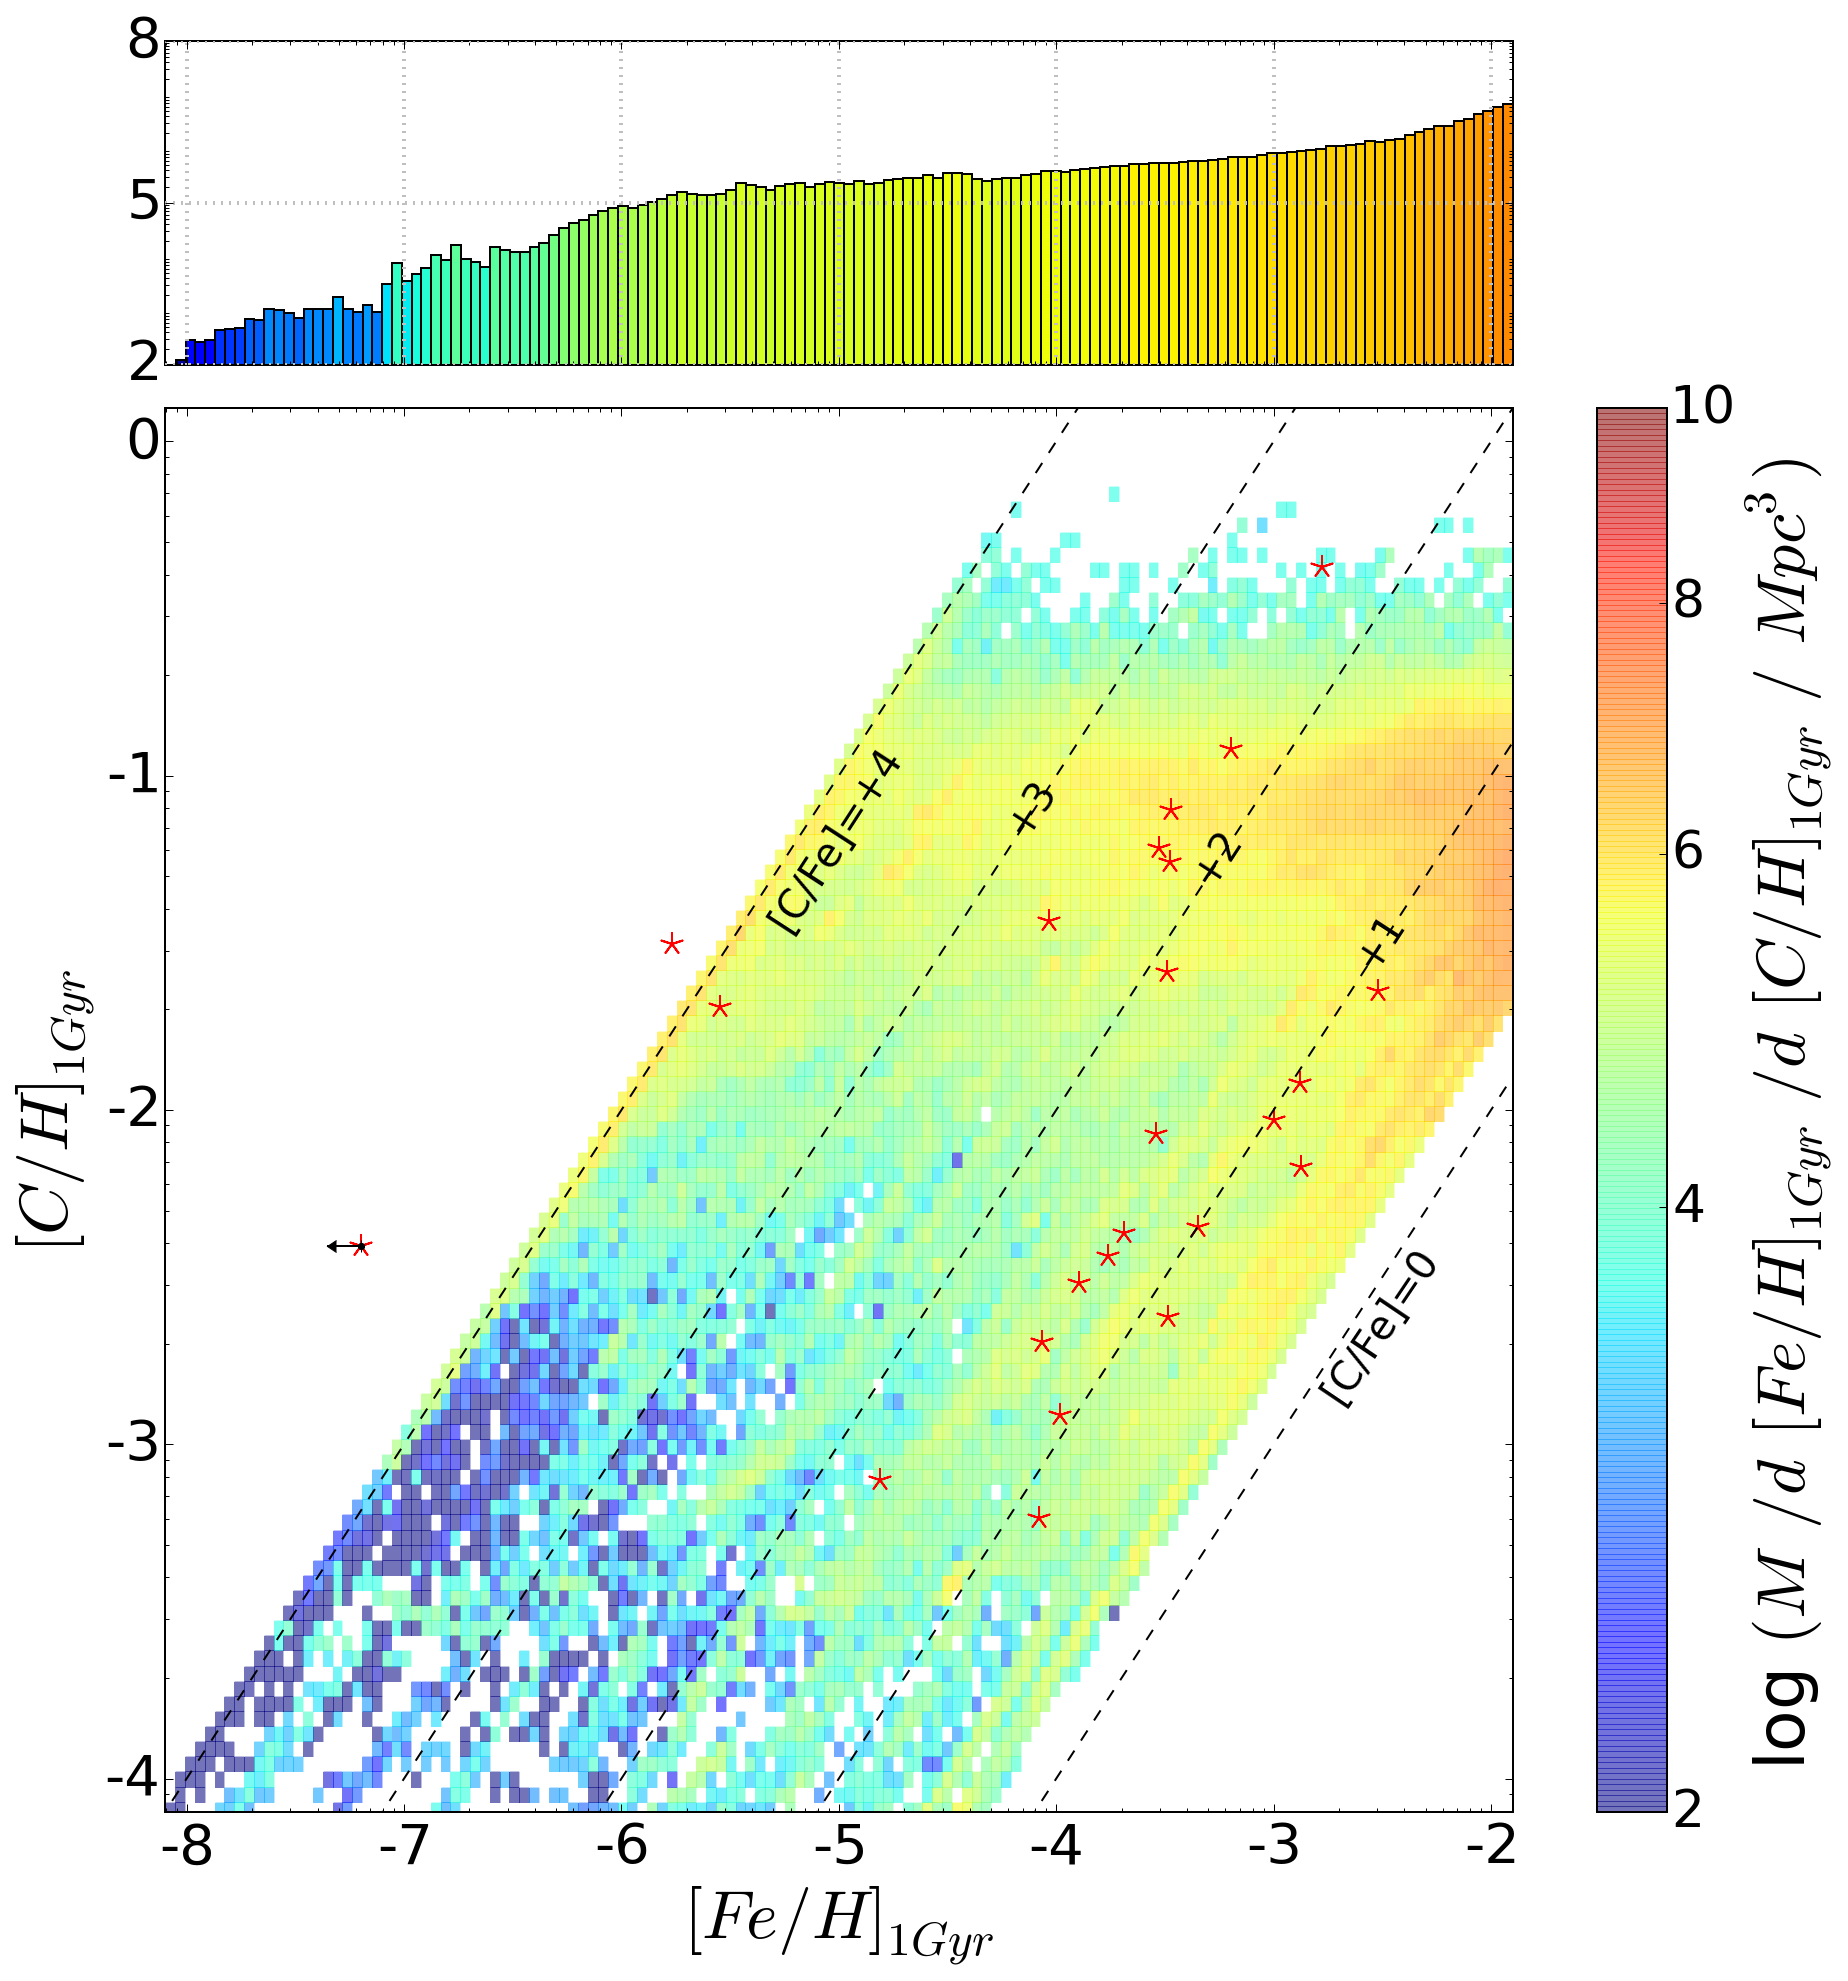

In [180]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{1Gyr}"
H, xedges, yedges = np.histogram2d(CH_mixedF/Csun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=57.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=57.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=57.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-5.0, 10**-1.0), 
                  horizontalalignment='center',size=20,rotation=57.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Add Keller CEMP star points
ax2dhist.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)

axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


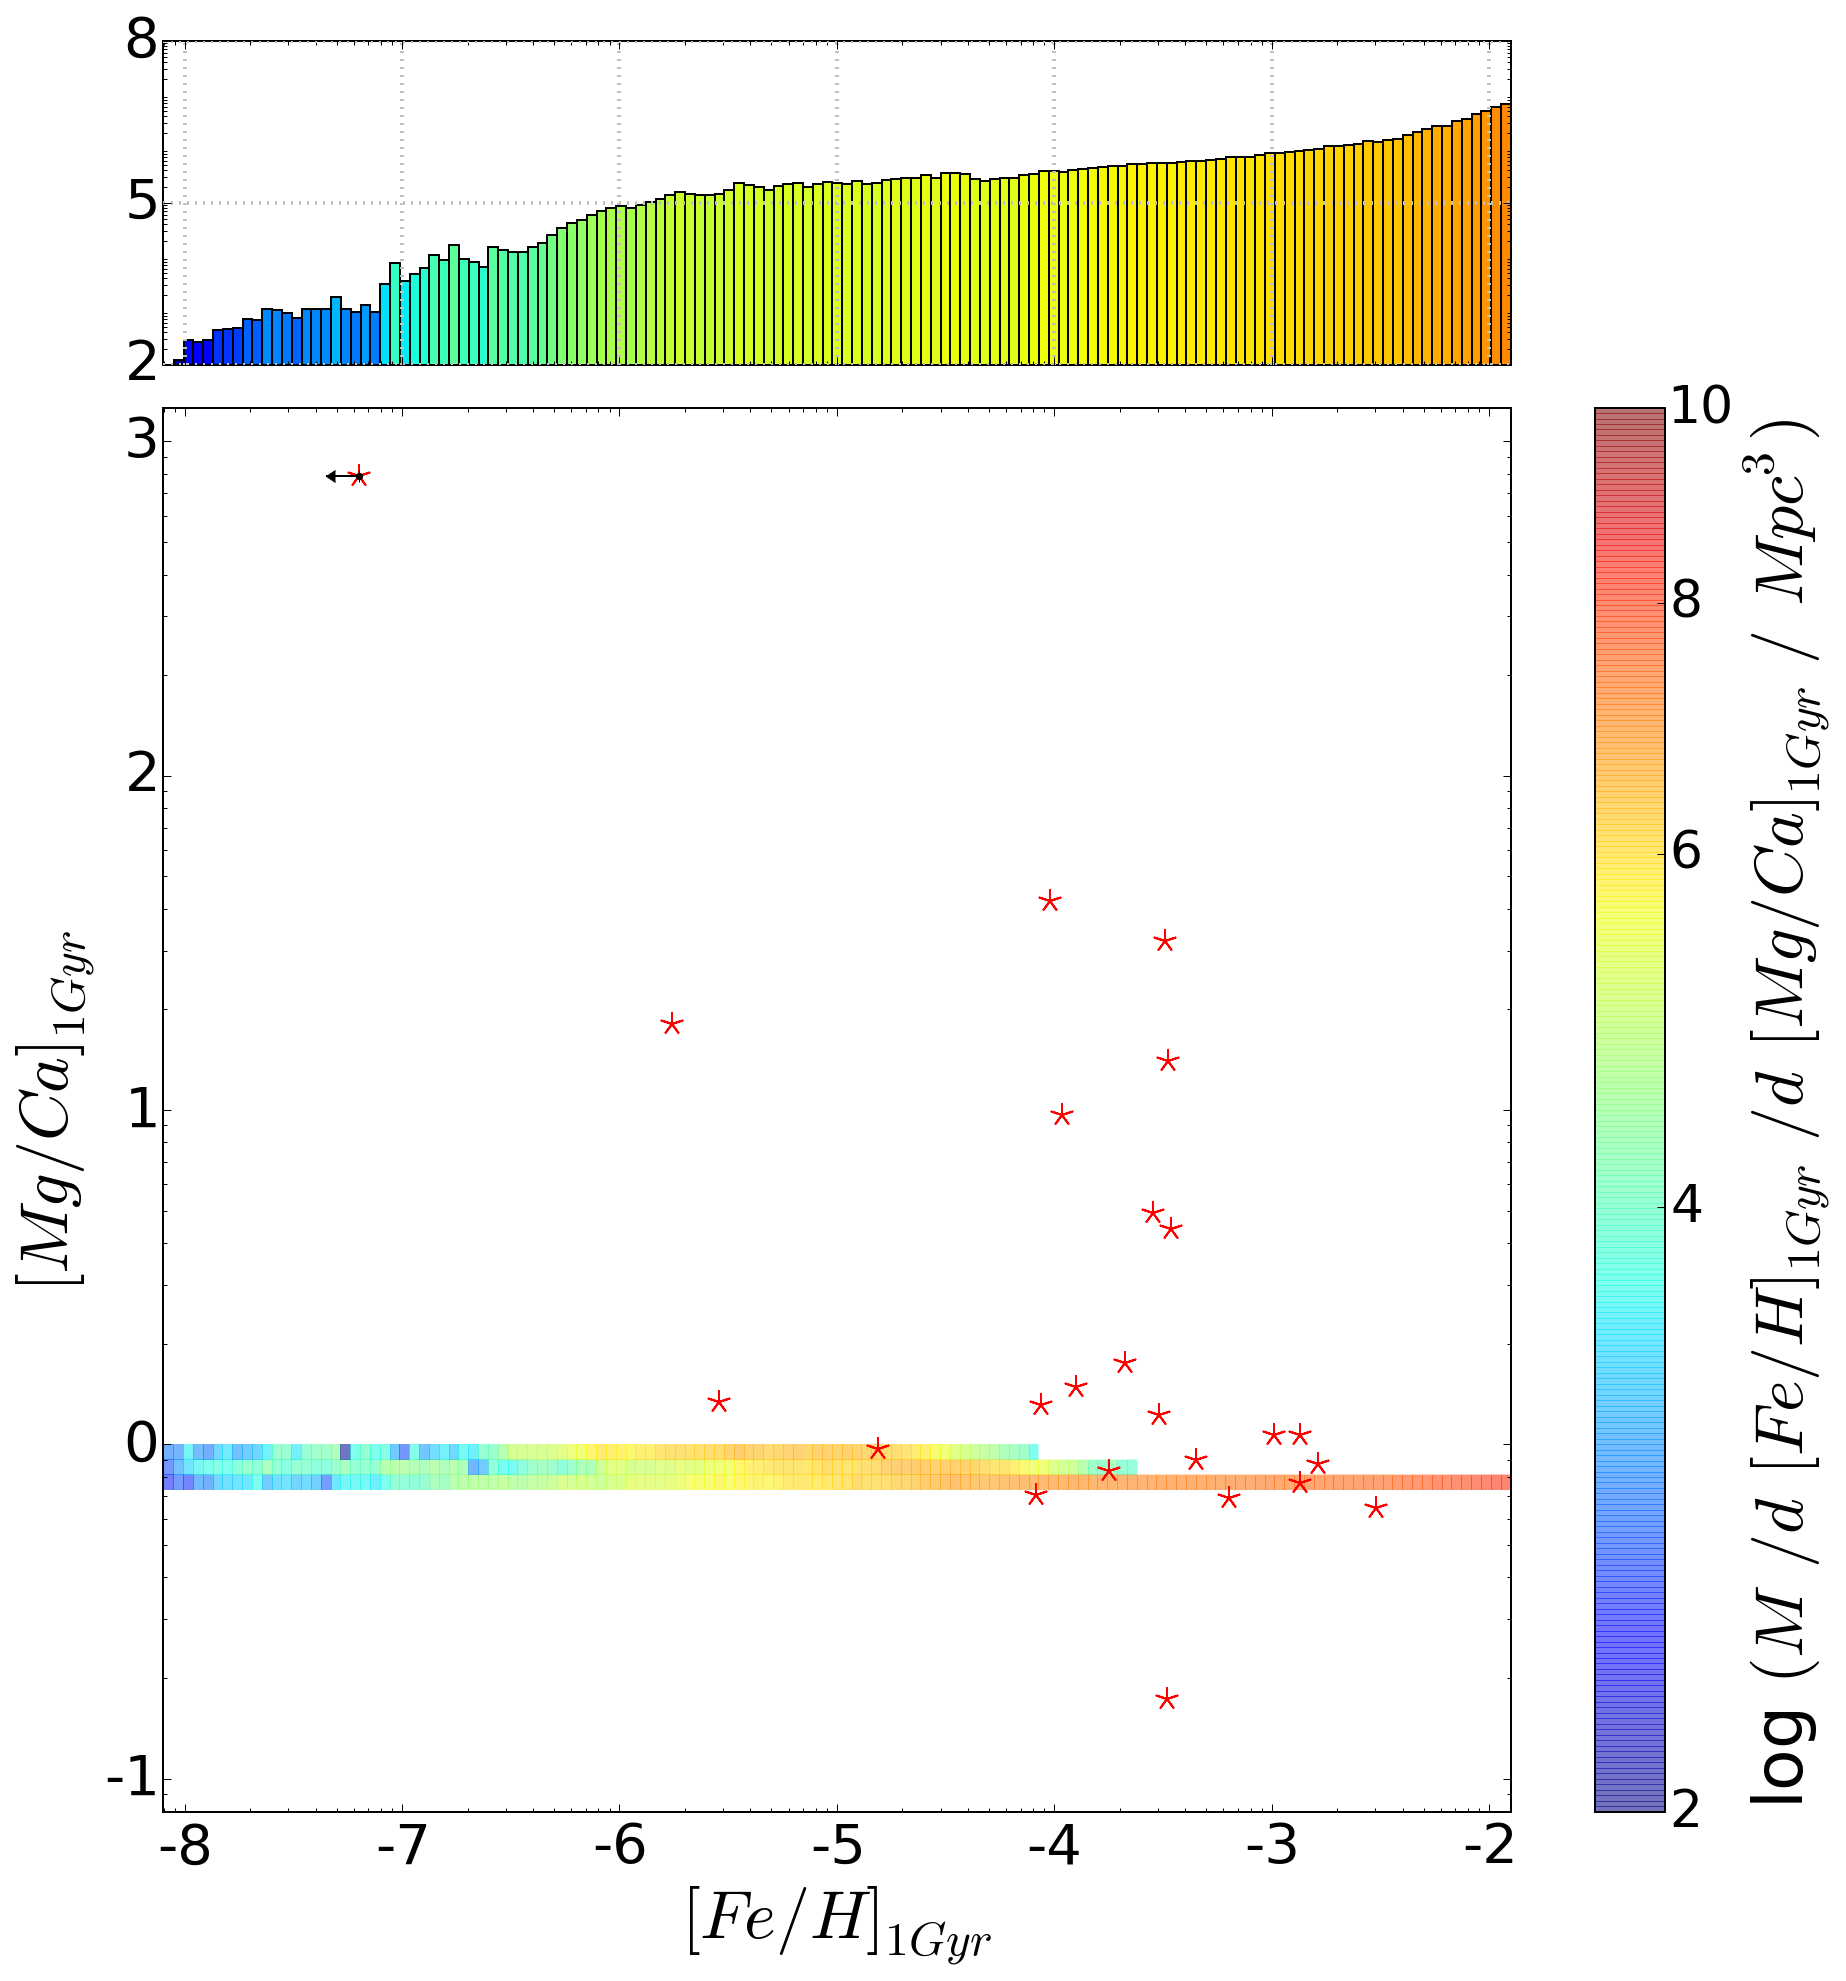

In [181]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]_{1Gyr}"

H, xedges, yedges = np.histogram2d(MgH_mixedF/Mgsun / (CaH_mixedF/Casun), FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
ax2dhist.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH_mixedF/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


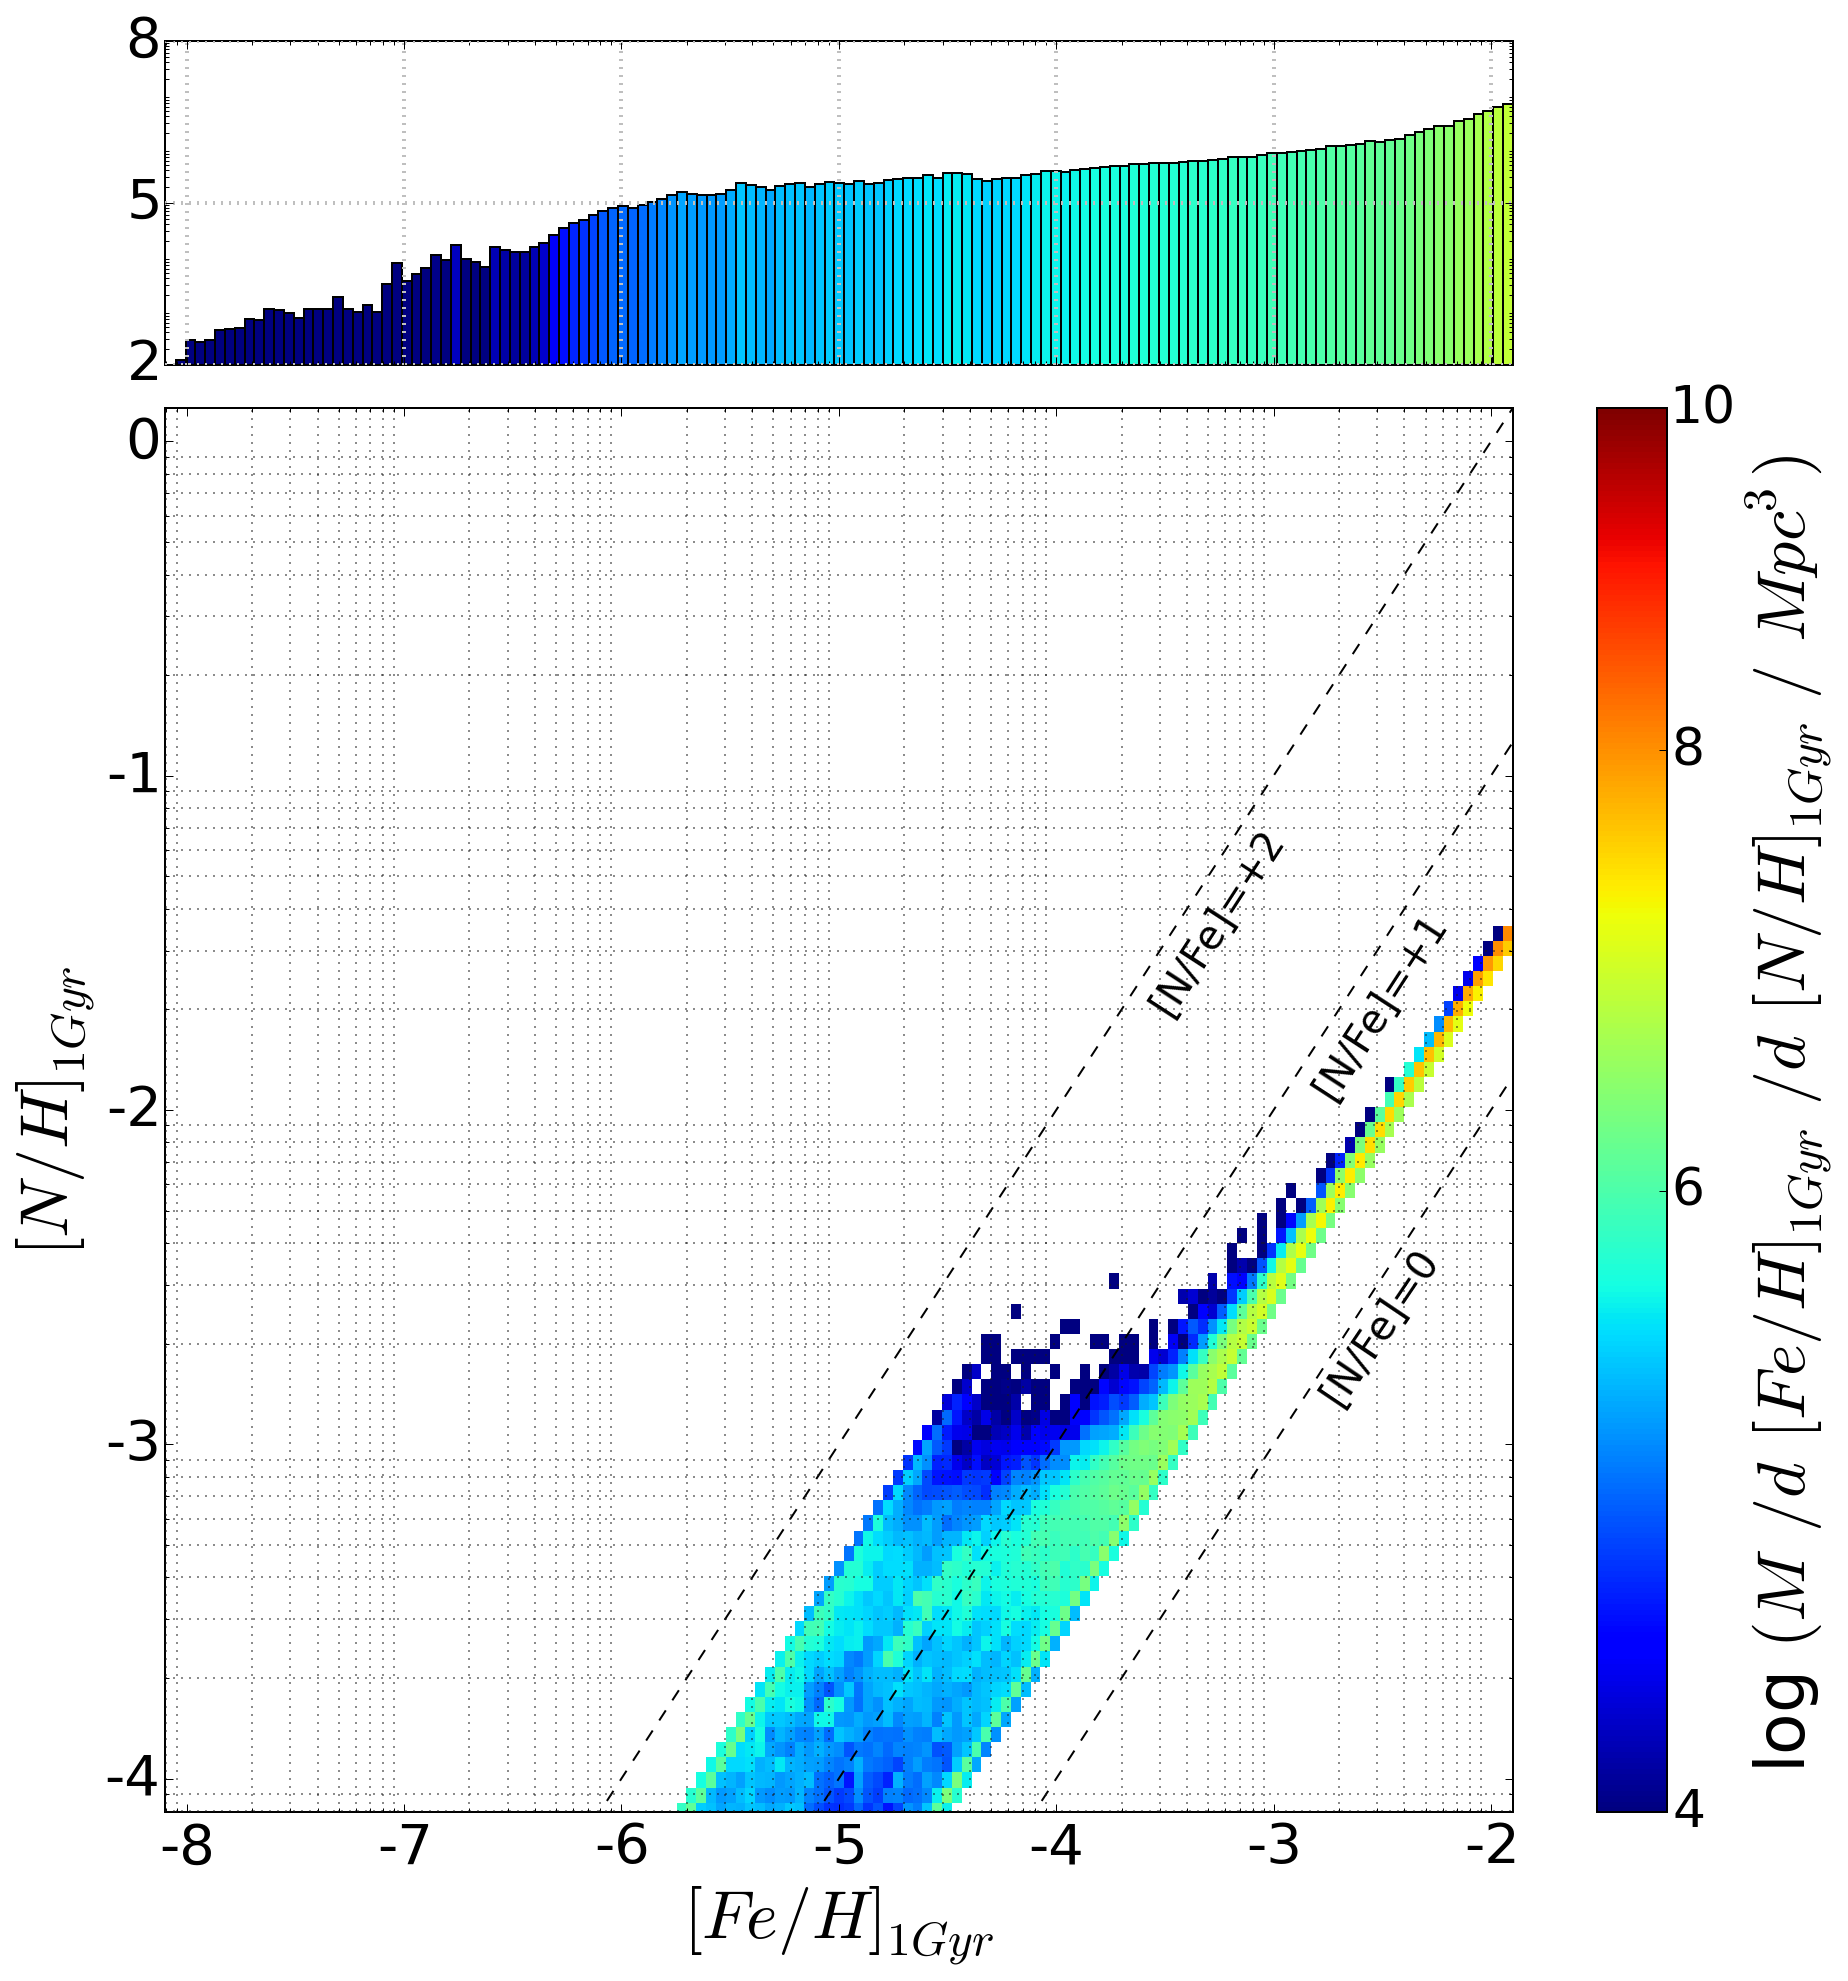

In [36]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[N/H]_{1Gyr}"
H, xedges, yedges = np.histogram2d(NH_mixedF/Nsun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 4
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[N/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[N/Fe]=+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=57.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[N/Fe]=+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=57.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)

axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


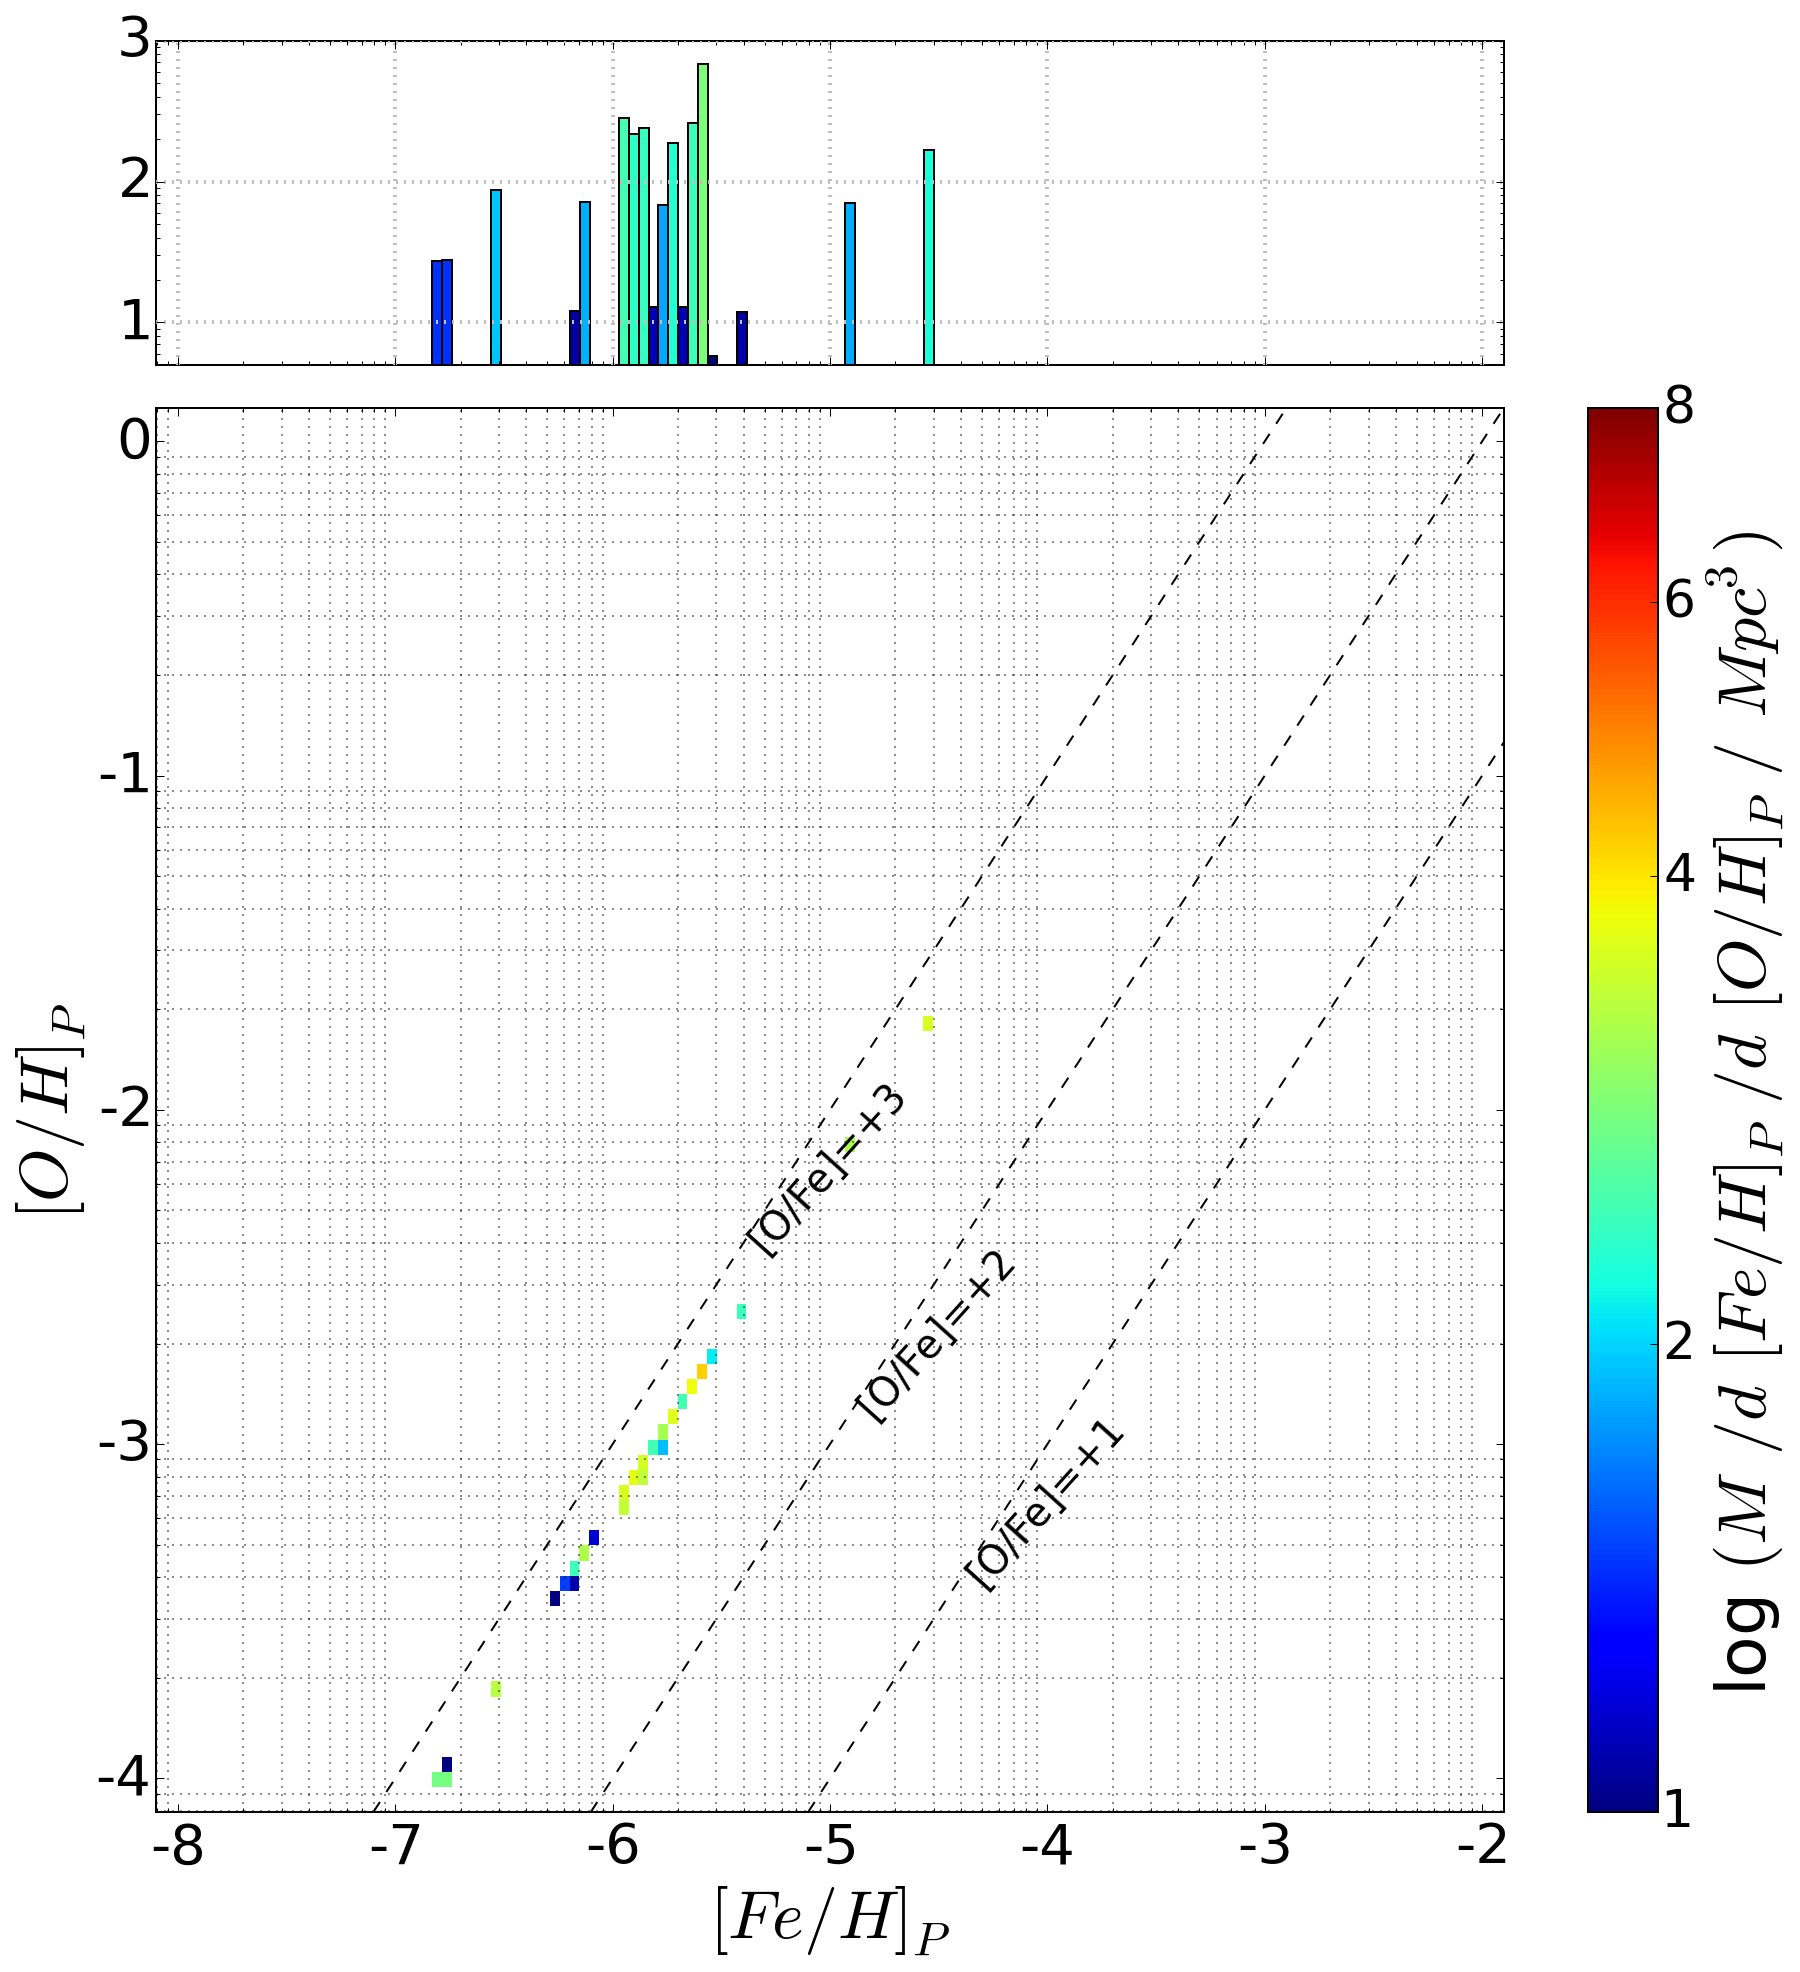

In [150]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
# Plot [O/H] vs [Fe/H]
yLabel = "[O/H]_{P}"
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plot = "[O/H]"
H, xedges, yedges = np.histogram2d(OH/Osun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)

#axHisty = plt.axes(rect_histy)

nullfmt = NullFormatter()

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

histMax = 3
cbarMax = 8
cbarMin = 1

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6., 10**-4), xytext=(10**-4.0, 10**-3), 
                  horizontalalignment='center',size=20,rotation=48.0)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6., 10**-4), xytext=(10**-4.5, 10**-2.50), 
                  horizontalalignment='center',size=20,rotation=48.0) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6., 10**-4), xytext=(10**-5, 10**-2), 
                  horizontalalignment='center',size=20,rotation=48.0) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1,2,4,6,cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Values should be along the 25 M_sun O yield line: [O/Fe] = 2.8

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH/Fesun, bins=xrange, log=True, 
                                weights=masses[priStars] * (1.0 - spPF[priStars]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([10.0**0.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e1, 1e2, 1e3])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks



# 30 M_sun Pop III SN
<|H -> 0.0334287, He -> 0.155618, 
 C -> 164.036, N -> 0.0887138, O -> 42.6579, F -> 2428.65, 
 Ne -> 78.1788, Na -> 1052.91, Mg -> 110.639, Al -> 220.169, 
 Si -> 58.4738, P -> 664.902, S -> 31.5478, Cl -> 75.8667, 
 Ar -> 41.8851, K -> 79.9935, Ca -> 60.5423, Sc -> 20936.6, 
 Ti -> 1238.45, V -> 2435.28, Cr -> 185.403, Mn -> 225.817, 
 Fe -> 2.99179, Co -> 460.54, Ni -> 34.7289|>

In [39]:
a = np.arange(1,10,0.5)
b = np.arange(1,5.26,0.25)
a,b,len(a),len(b)

(array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
         6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,
         3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25]),
 18,
 18)

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


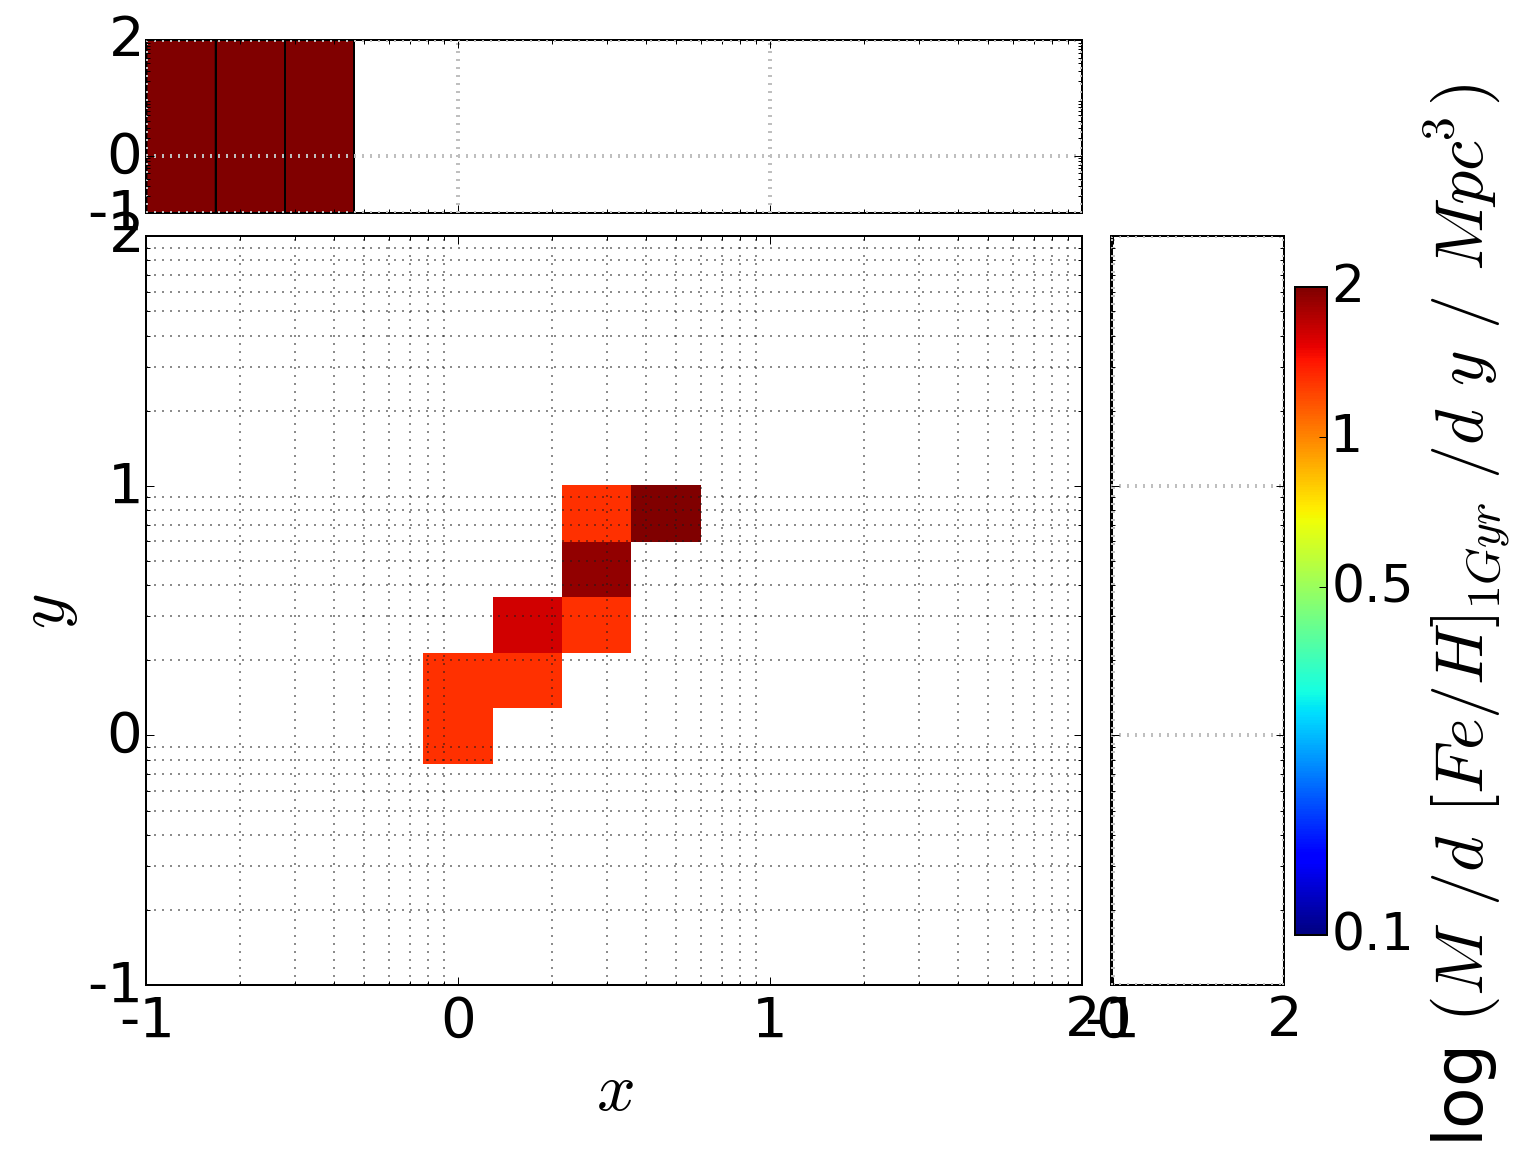

In [41]:
xrange = np.logspace(-1,1,10)
yrange = np.logspace(-1,1,10)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "y"
H, xedges, yedges = np.histogram2d(a, b, bins=(yrange,xrange))
# Compute the normalizing factors... 
#H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(10, 8))
ax2dhist = plt.axes(rect_2dhist)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

histMax = 2
cbarMin = 1e-1
cbarMax = 2

minY = -1; maxY = 2
minX = -1; maxX = 2

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$x$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1e-1, 0.5, 1, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True)
normBarHeight(bins, patches, cmvol)

axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e-1,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e-1, 1e0, 10.0**histMax])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

N, bins, patches = axHisty.hist(CH_mixedF/Csun, bins=yrange, log=True)
normBarHeight(bins, patches, cmvol, rotated=True)
axHisty.set_yscale('log')
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

axHisty.set_xlim([1e-1,10.0**histMax])     # We're rotated, so x axis is the value
axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
axHisty.tick_params(labelsize=labelsize)
axHisty.xaxis.set_ticks([1e-1, 1e0, 10.0**histMax])
axHisty.grid(color='0.75', linestyle=':', linewidth=2)
axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHisty.yaxis.set_major_formatter(nullfmt)


In [187]:
H

masked_array(data =
 [[-- -- -- --]
 [-- -- -- --]
 [-- -- 1.4471580313422192 0.6020599913279624]
 [-- -- 0.6020599913279624 0.6020599913279624]],
             mask =
 [[ True  True  True  True]
 [ True  True  True  True]
 [ True  True False False]
 [ True  True False False]],
       fill_value = 1e+20)